# Problem Set 2
By: Bethany Bailey  
MACS 30100

## Question 1
### (a)

In [1]:
import numpy as np
import scipy.stats as sts

incomes = np.loadtxt('incomes.txt')

<IPython.core.display.Javascript object>


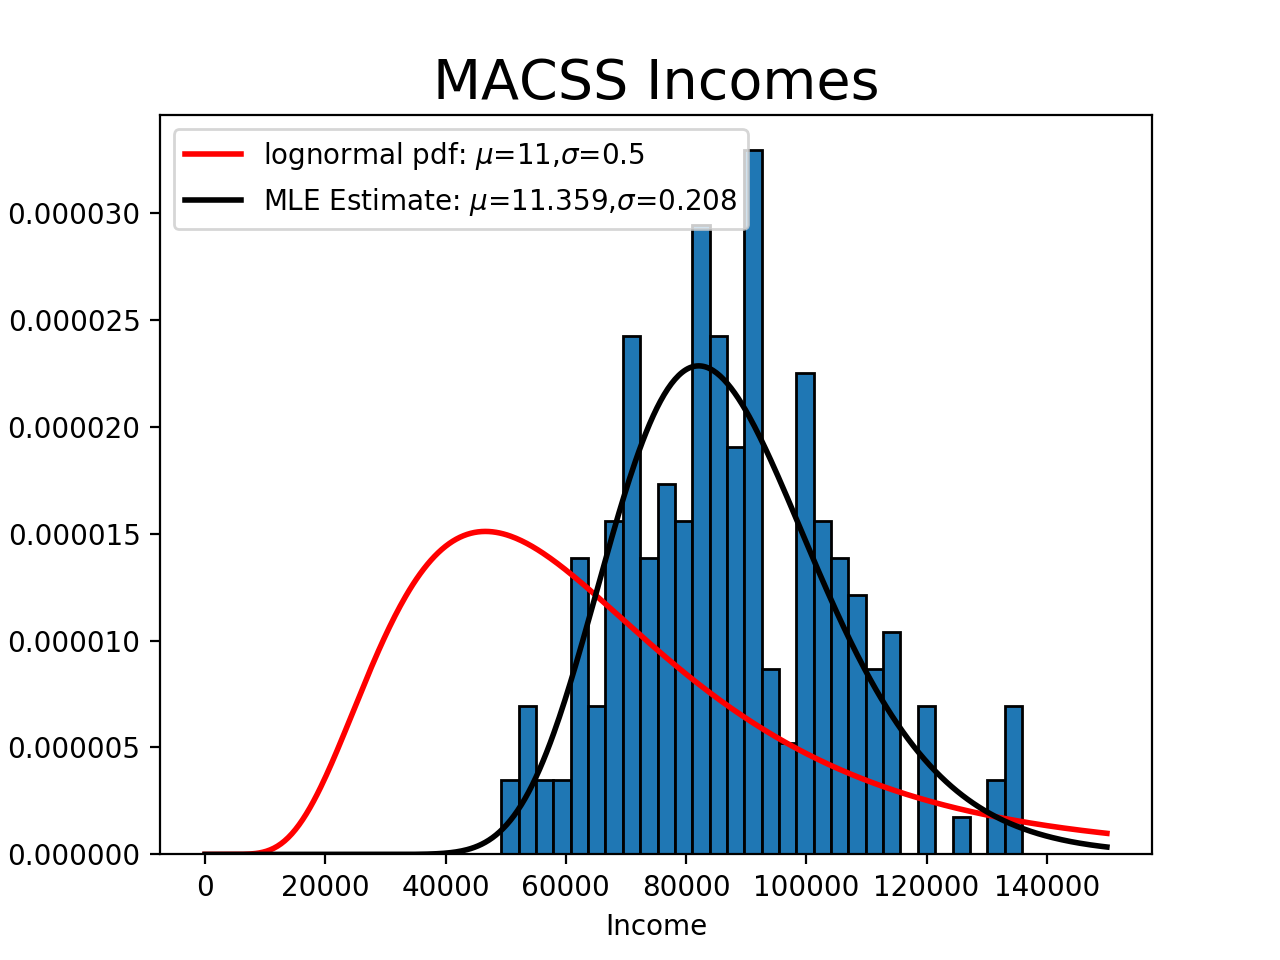

Text(0,0.5,'Percent of Students')

In [24]:
import matplotlib.pyplot as plt
%matplotlib notebook
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('MACSS Incomes', fontsize=20)
plt.xlabel('Income')
plt.ylabel('Percent of Students')

### (b)

In [25]:
def lognormal_pdf(xvals, mu, sigma, cutoff):
    
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.norm.cdf(0, loc=mu, scale=sigma)
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp(-(np.log(xvals)- mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [26]:
dist_pts = np.linspace(0.1, 150000, 500)
mu_1 = 11
sig_1 = 0.5
plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_1, sig_1, 150000),
         linewidth=2, color='r', label='lognormal pdf: $\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

In [27]:
def log_lik(xvals, mu, sigma, cutoff):
    pdf_vals = lognormal_pdf(xvals, mu, sigma, cutoff)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print("The log likelihood value given this data for this parameterization is ", log_lik(incomes, mu_1, sig_1, 150000))

The log likelihood value given this data for this parameterization is  -2385.85699781


### (c)

In [28]:
def crit(params, *args):
    mu, sigma = params
    xvals, cutoff = args
    log_lik_val = log_lik(xvals, mu, sigma, cutoff)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [29]:
import scipy.optimize as opt

mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
mle_args = (incomes, 150000)
results = opt.minimize(crit, params_init, args=(mle_args),
                       method='L-BFGS-B',
                       bounds = ((0.1, None), (0.1, None)))
mu_MLE, sig_MLE = results.x
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv.todense() * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('mu_MLE estimate =', mu_MLE, ' sig_MLE estimate =', sig_MLE)
print('likelihood function =', log_lik(incomes, mu_MLE, sig_MLE, 150000))
print('variance-covariance matrix(MLE) = ')
print(vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)
print('See graph above.')

mu_MLE estimate = 11.3590243967  sig_MLE estimate = 0.208178530156
likelihood function = -2241.71930137
variance-covariance matrix(MLE) = 
[[  2.52831353e-04  -2.76208826e-05]
 [ -2.76208826e-05   1.30457089e-04]]
Standard error for mu estimate =  0.0159006714777
Standard error for sigma estimate =  0.0114217813365
See graph above.


In [30]:
plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_MLE, sig_MLE, 150000),
         linewidth=2, color='k', label='MLE Estimate: $\mu$=11.359,$\sigma$=0.208')
plt.legend(loc='upper left')
print('See graph above.')

See graph above.


### (d)

In [31]:
log_lik_h0 = log_lik(incomes, mu_1, sig_1, 150000)
log_lik_mle = log_lik(incomes, mu_MLE, sig_MLE, 150000)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('The chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)
print('The probability that the income data came from the distribution in part b is', pval_h0)

The chi squared of H0 with 2 degrees of freedom p-value =  0.0
The probability that the income data came from the distribution in part b is 0.0


### (e)

In [32]:
greater_100000 = 1 - sts.lognorm.cdf(100000, scale = np.exp(mu_MLE), s = sig_MLE)
less_75000 = sts.lognorm.cdf(75000, scale = np.exp(mu_MLE), s = sig_MLE)

print("The probability that an individual will earn more than $100,000 is", greater_100000)
print("The probability that an individual will earn more than $75,000 is", less_75000)

The probability that an individual will earn more than $100,000 is 0.229870180558
The probability that an individual will earn more than $75,000 is 0.260233297923


## Question 2
### (a)

In [11]:
import pandas as pd

In [12]:
sick_data = pd.read_csv("sick.txt")
sick_data.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [13]:
# Pull the data from the dataframe.
age = sick_data["age"]
children = sick_data["children"]
temp_winter = sick_data["avgtemp_winter"]
sick = sick_data["sick"]

In [14]:
def neg_log_lik(sigma, error, mu):
    pdf_vals = pdf_vals = 1/ (sigma * np.sqrt(2 * np.pi)) * np.exp( - (error - mu)**2 / (2 * sigma**2))
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return -log_lik_val

In [15]:
def crit2(params, *args):
    b0, b1, b2, b3, sigma = params
    age, children, temp_winter, sick = args
    error = sick - b0 - b1 * age - b2 * children - b3 * temp_winter
    neg_log_like_val = neg_log_lik(sigma, error, 0)
        
    return neg_log_like_val

In [16]:
params_init = (0, 0, 0, 0, 1)
model_args = (age, children, temp_winter, sick)
results2 = opt.minimize(crit2, params_init, args=model_args)

/Users/bethanybailey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/bethanybailey/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/bethanybailey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
print("The estimates for b0, b1, b2, b3, and sigma are :", results2.x)

The estimates for b0, b1, b2, b3, and sigma are : [ 0.25164688  0.01293339  0.40050165 -0.00999171  0.00301775]


In [18]:
print("The log likelihood is", -results2.fun)

The log likelihood is 876.8650468449088


In [19]:
OffDiagNeg2 = np.eye(5)*2-1
vcv_mle2 = results2.hess_inv * OffDiagNeg2 # this form of the hess_inv does not have the todense() method, so
# I did not run it.
stderr_mu_mle2 = np.sqrt(vcv_mle2[0,0])
stderr_sig_mle2 = np.sqrt(vcv_mle2[1,1])
print('variance-covariance matrix(MLE) = ')
print(vcv_mle2)
print('Standard error for mu estimate = ', stderr_mu_mle2)
print('Standard error for sigma estimate = ', stderr_sig_mle2)

variance-covariance matrix(MLE) = 
[[  8.96958517e-07  -1.18251942e-08   2.02569992e-07   2.28210177e-08
   -3.55593030e-09]
 [ -1.18251942e-08   3.88555784e-09   3.42978702e-08   2.54793107e-09
   -2.08497972e-11]
 [  2.02569992e-07   3.42978702e-08   3.56037130e-07  -2.26827527e-08
    1.87350190e-09]
 [  2.28210177e-08   2.54793107e-09  -2.26827527e-08   2.01414703e-09
    5.20438397e-11]
 [ -3.55593030e-09  -2.08497972e-11   1.87350190e-09   5.20438397e-11
    2.31573875e-08]]
Standard error for mu estimate =  0.000947078939302
Standard error for sigma estimate =  6.233424288e-05


### (b)

In [20]:
h0_params = (1, 0, 0, 0, 0.01)
log_lik_h02 = crit2(h0_params, age, children, temp_winter, sick)
log_lik_mle2 = crit2(results2.x, age, children, temp_winter, sick)
LR_val2 = 2 * (log_lik_mle - log_lik_h0)
pval_h02 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('The chi squared of H0 with 2 degrees of freedom p-value = ', pval_h02)
print('The probability that age, number of children, and average winter temperature have no')
print('effect on the number of sick days is', pval_h02)

The chi squared of H0 with 2 degrees of freedom p-value =  0.0
The probability that age, number of children, and average winter temperature have no
effect on the number of sick days is 0.0


/Users/bethanybailey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
